In [ ]:
#Importing necessary libraries
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA


In [ ]:
# Step 1: Download stock price data (using Apple as an example)
ticker = "AAPL"
data = yf.download(ticker, start="2021-01-01", end="2021-06-01")
data = data['Close']  # Using the closing price

[*********************100%***********************]  1 of 1 completed


In [ ]:
data

,Close
Date,
2021-01-04,129.410004
2021-01-05,131.009995
2021-01-06,126.599998
2021-01-07,130.919998
2021-01-08,132.050003
...,...
2021-05-24,127.099998
2021-05-25,126.900002
2021-05-26,126.849998


In [ ]:
# Step 2: Check for stationarity using Augmented Dickey-Fuller (ADF) test
def check_stationarity(timeseries):
    result = adfuller(timeseries)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] > 0.05:
        print("The time series is non-stationary.")
    else:
        print("The time series is stationary.")

# Check stationarity of the raw data
print("Checking stationarity of the raw data:")
check_stationarity(data)



Checking stationarity of the raw data:
ADF Statistic: -2.025561074683463
p-value: 0.27547912329068835
The time series is non-stationary.


In [ ]:
# If non-stationary, take the first difference to make it stationary
data_diff = data.diff().dropna()

print("\nChecking stationarity of the differenced data:")
check_stationarity(data_diff)




Checking stationarity of the differenced data:
ADF Statistic: -5.124409175473235
p-value: 1.2518213559834074e-05
The time series is stationary.


<Figure size 1200x600 with 0 Axes>

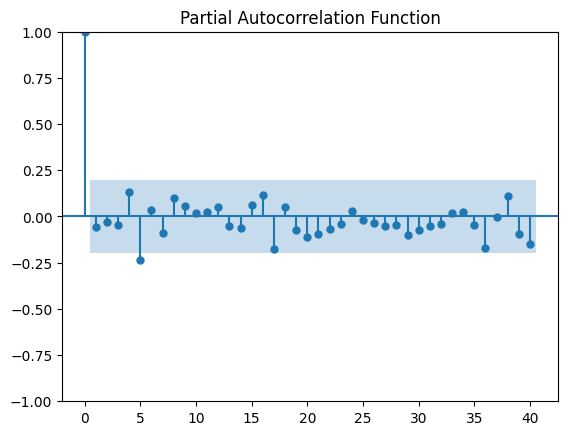

In [ ]:
# Step 3: PACF to determine AR parameter (p)
plt.figure(figsize=(12, 6))

# Plot PACF
plot_pacf(data_diff, lags=40)
plt.title("Partial Autocorrelation Function")
plt.show()


In [ ]:
p = 5 # AR term (adjust based on the PACF plot)

# Step 4: Split the data into train and test sets
train_size = int(len(data_diff) * 0.9)  # 90% for training, 10% for testing
train_data, test_data = data_diff[:train_size], data_diff[train_size:]

In [ ]:
# Step 5: Fit the AR model on training data
model = AutoReg(train_data, lags = 5 )
ar_result = model.fit()
print(ar_result.summary())


                            AutoReg Model Results                             
Dep. Variable:                  Close   No. Observations:                   90
Model:                     AutoReg(5)   Log Likelihood                -189.887
Method:               Conditional MLE   S.D. of innovations              2.259
Date:                Wed, 18 Sep 2024   AIC                            393.774
Time:                        17:25:27   BIC                            410.872
Sample:                             5   HQIC                           400.651
                                   90                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0395      0.245     -0.161      0.872      -0.520       0.441
Close.L1       0.0381      0.103      0.369      0.712      -0.164       0.240
Close.L2       0.0157      0.103      0.153      0.8

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
# Step 6: Get AIC and BIC values
aic_value = ar_result.aic
bic_value = ar_result.bic
print(f"AIC: {aic_value}")
print(f"BIC: {bic_value}")


AIC: 393.7737605192931
BIC: 410.8723193147253


In [ ]:

# Step 7: Make predictions on the test data
predicted_values = ar_result.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1, dynamic=False)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [ ]:
data[train_size]

<ipython-input-25-a3ea30d0e3af>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data[train_size]


124.97000122070312

In [ ]:
# Step 8: Revert differencing to compare predictions with actual prices
# Add the last value of the training data to the cumulative sum of predicted differences to get predicted prices
predicted_prices = np.cumsum(predicted_values) + data[train_size]


<ipython-input-26-f63ec95774e1>:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_prices = np.cumsum(predicted_values) + data[train_size]


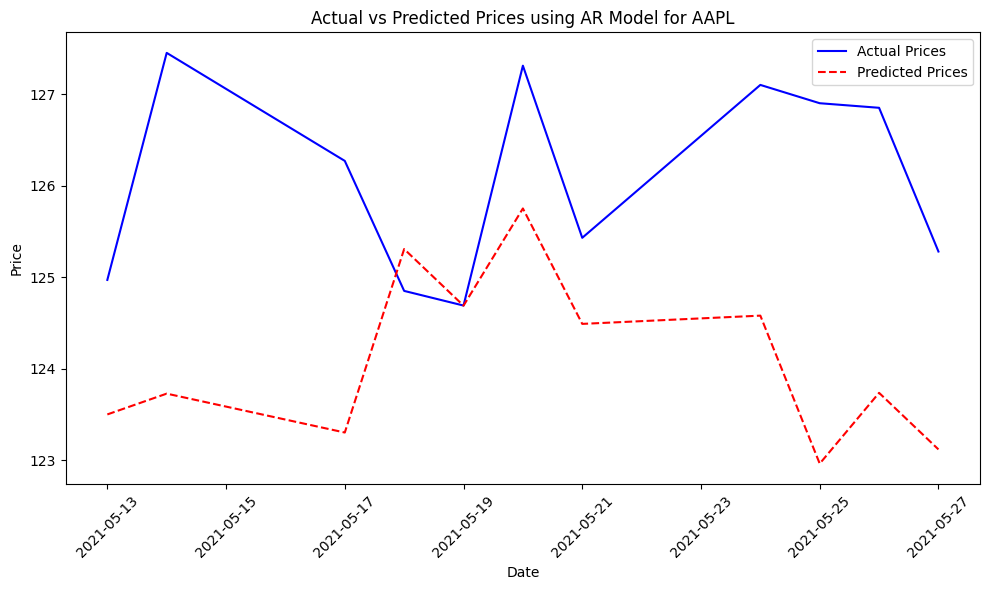

In [ ]:
# Ensure the lengths of actual and predicted values match
actual_prices = data[train_size:train_size + len(predicted_prices)]  # Slice actual data to match predicted length
actual_dates = data.index[train_size:train_size + len(predicted_prices)]  # Corresponding dates for plotting

# Step 9: Plot actual vs predicted prices, using dates on the x-axis
plt.figure(figsize=(10, 6))

# Plot actual prices with corresponding dates
plt.plot(actual_dates, actual_prices, label='Actual Prices', color='blue')

# Plot predicted prices with the same corresponding dates
plt.plot(actual_dates, predicted_prices, label='Predicted Prices', color='red', linestyle='--')

# Add labels and title
plt.title(f'Actual vs Predicted Prices using AR Model for {ticker}')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)  # Rotate the date labels for better readability
plt.legend()
plt.tight_layout()  # Adjust layout to ensure everything fits without overlap
plt.show()


<ipython-input-28-7e479f8dbc87>:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot([actual_dates[i], actual_dates[i+1]], [actual_prices[i], actual_prices[i+1]], color='green', label='Correct Prediction' if i == 0 else "")
<ipython-input-28-7e479f8dbc87>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot([actual_dates[i], actual_dates[i+1]], [actual_prices[i], actual_prices[i+1]], color='green', label='Correct Prediction' if i == 0 else "")
<ipython-input-28-7e479f8dbc87>:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be tre

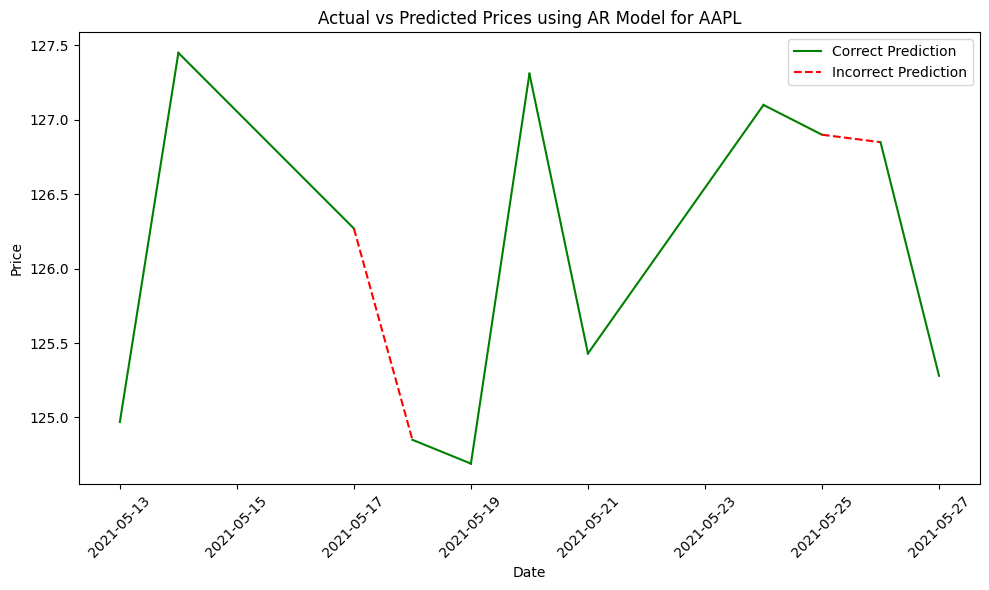

In [ ]:
last_train_value = data.iloc[train_size ]  # Last value before predictions start

# Add cumulative sum of predicted differences to the last actual price
predicted_prices = np.cumsum(predicted_values) + last_train_value

# Ensure the lengths of actual and predicted values match
actual_prices = data[train_size:train_size + len(predicted_prices)]  # Slice actual data to match predicted length
actual_dates = data.index[train_size:train_size + len(predicted_prices)]  # Corresponding dates for plotting

# Calculate daily changes (differences) for actual and predicted prices
actual_diff = np.diff(actual_prices)  # Difference between consecutive actual prices
predicted_diff = np.diff(predicted_prices)  # Difference between consecutive predicted prices

# Step 9: Plot actual vs predicted prices, with conditional color-coding
plt.figure(figsize=(10, 6))

# Loop through the differences and plot accordingly
neg = 0
for i in range(len(actual_diff)):
    # If both predicted and actual values increased, plot in green
    if actual_diff[i] > 0 and predicted_diff[i] > 0:
        plt.plot([actual_dates[i], actual_dates[i+1]], [actual_prices[i], actual_prices[i+1]], color='green', label='Correct Prediction' if i == 0 else "")
    #if both predicted and actual values decreased, plot in green
    elif actual_diff[i] < 0 and predicted_diff[i] < 0:
      plt.plot([actual_dates[i], actual_dates[i+1]], [actual_prices[i], actual_prices[i+1]], color='green', label='Correct Prediction' if i == 0 else "")
    #otherwise plot in red
    else:
        plt.plot([actual_dates[i], actual_dates[i+1]], [actual_prices[i], actual_prices[i+1]], color='red', linestyle='--', label='Incorrect Prediction' if neg==0 else "")
        neg = 1
# Plot labels and title
plt.title(f'Actual vs Predicted Prices using AR Model for {ticker}')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)  # Rotate the date labels for better readability

# Add legend for the first occurrence of each color
plt.legend()

# Adjust layout to avoid label overlap
plt.tight_layout()

# Display the plot
plt.show()
